# Learning to use emukit

## Intro
Emukit was developed to improve on `GPyOpt` by adding:
- modular surrogate models
- modular acquisition functions

> "The current version of Emukit includes multi-fidelity emulation for build surrogate models when data is obtained from multiple information sources that have different fidelity and/or cost; Bayesian optimisation for optimising physical experiments and tune parameters of machine learning algorithms or other computational simulations; experimental design and active learning: design the most informative experiments and perform active learning with machine learning models; sensitivity analysis: analyse the influence of inputs on the outputs of a given system; and Bayesian quadrature: efficiently compute the integrals of functions that are expensive to evaluate."

We're probably interested in running BO to "tune" our GP. Although I don't understand — _GPs are nonparametric, so running BO would be the actual learning process, i.e. finding a posterior distributions that explains the data._

In [1]:
%pip install mlai gpy pyDOE emukit

  Using cached mlai-0.1.2-py2.py3-none-any.whl (42 kB)
     |████████████████████████████████| 1.5 MB 1.4 MB/s eta 0:00:01
  Using cached pyDOE-0.3.8.zip (22 kB)
  Using cached emukit-0.4.9-py3-none-any.whl (241 kB)
  Using cached pods-0.1.13-py2.py3-none-any.whl (56 kB)
  Using cached Cython-0.29.26-py2.py3-none-any.whl (983 kB)
  Using cached paramz-0.9.5.tar.gz (71 kB)
     |████████████████████████████████| 33.2 MB 1.6 MB/s eta 0:00:01
  Using cached emcee-3.1.1-py2.py3-none-any.whl (45 kB)
     |████████████████████████████████| 26.5 MB 3.3 MB/s eta 0:00:01     |████████████████                | 13.3 MB 2.5 MB/s eta 0:00:06
  Using cached tenacity-8.0.1-py3-none-any.whl (24 kB)
     |████████████████████████████████| 6.0 MB 370 kB/s eta 0:00:01
     |████████████████████████████████| 98 kB 3.3 MB/s eta 0:00:01
  Created wheel for pyDOE: filename=pyDOE-0.3.8-py3-none-any.whl size=18184 sha256=b6fffb3c581b1d220b7005e4b5c06b1585a46913e7d5de997608486f93a5a1cb
  Stored in directory: /U

The user should know:
1. Which questions they want to answer in regard to their process/simulation;
2. Which emulation techniques are needed to answer these questions;

For us, the question (in my mind) is how to/if we can get better uncertainty estimates when we forecast precipitation from an ESM using a Gaussian process.

To add a model to `emukit`, you create it using a different framework of your choice, then implement a bunch of interfaces to make it work. There is a wrapper for models in `GPy`.

## Getting emukit ready

In [14]:
import numpy as np
import GPy
import matplotlib.pyplot as plt

from emukit.experimental_design.experimental_design_loop import ExperimentalDesignLoop

In [2]:
ExperimentalDesignLoop?

Init signature:
ExperimentalDesignLoop(
    space: emukit.core.parameter_space.ParameterSpace,
    model: emukit.core.interfaces.models.IModel,
    acquisition: emukit.core.acquisition.acquisition.Acquisition = None,
    update_interval: int = 1,
    batch_size: int = 1,
    acquisition_optimizer: emukit.core.optimization.acquisition_optimizer.AcquisitionOptimizerBase = None,
)
Docstring:     
Generic outer loop that provides the framework for decision making parts of Emukit.

The loop can be used in two modes:

1. Emukit calculates the next point(s) to try and evaluates your function at these points until some stopping
   criterion is met.
2. Emukit only calculates the next points(s) to try and you evaluate your function or perform the experiment.

This object exposes the following events. See ``emukit.core.event_handler`` for details of how to subscribe:
     - ``loop_start_event`` called at the start of the `run_loop` method
     - ``iteration_end_event`` called at the end of each i

In [3]:
from emukit.model_wrappers import SimpleGaussianProcessModel

ARD := automatic relevance determination

In [4]:
SimpleGaussianProcessModel?

Init signature: SimpleGaussianProcessModel(x: numpy.ndarray, y: numpy.ndarray)
Docstring:     
This model is a Gaussian process with an RBF kernel, with no ARD. It is used to demonstrate uses of emukit,
it does not aim to be flexible, robust or fast.
Init docstring:
:param x: (n_points, n_dims) array containing training features
:param y: (n_points, 1) array containing training targets
File:           ~/anaconda3/envs/surrogate/lib/python3.9/site-packages/emukit/model_wrappers/simple_gp_model.py
Type:           type
Subclasses:     


## Creating data

I think these are observations: we observe 10 datapoints between $[-30, 30]$.

In [7]:
x_min = -30.0
x_max = 30.0

x = np.random.uniform(x_min, x_max, (10, 1))
y = np.sin(x) + np.random.randn(10, 1) * 0.05

x, y

(array([[-13.74110259],
        [-23.66565672],
        [ -5.75436839],
        [  8.08068268],
        [-27.17643217],
        [-29.34359169],
        [  7.45919186],
        [-17.93467775],
        [  9.19903242],
        [  3.87942782]]),
 array([[-0.9705776 ],
        [ 1.05559395],
        [ 0.43324867],
        [ 0.96437402],
        [-0.86880277],
        [ 0.86805806],
        [ 0.93025744],
        [ 0.78047266],
        [ 0.24014362],
        [-0.75547578]]))

In [8]:
model = SimpleGaussianProcessModel(x, y)

In [9]:
from emukit.core import ParameterSpace, ContinuousParameter
from emukit.core.loop import UserFunctionWrapper

In [10]:
# What is the interpretation of these two quantities?
p = ContinuousParameter("c", x_min, x_max) # A parameter which is continuous between [x_min, x_max]
space = ParameterSpace([p])  # A parameter space consisting of just p — why?

In [23]:
loop = ExperimentalDesignLoop(space, model)
loop.run_loop(np.sin, 30) # Fit the data using a sine wave for 30 iterations of the outer loop.

The real data is between $[-40, 40]$ at $0.2$ increments.

In [12]:
plot_min = -40.0
plot_max = 40.0

real_x = np.arange(plot_min, plot_max, 0.2)
real_y = np.sin(real_x)

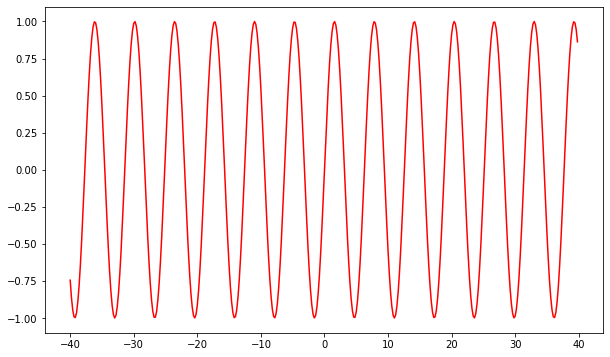

In [20]:
fig, ax = plt.subplots(figsize = (10, 6))
ax.plot(real_x, real_y, color="red")
plt.show()

## Compute predictions from emukit

In [19]:
predicted_y, predicted_std = [], []
for x in real_x:
    y, var = model.predict(np.array([[x]])) # Why this shape?
    std = np.sqrt(var)
    predicted_y.append(y)
    predicted_std.append(std)
    
predicted_y = np.array(predicted_y).flatten()
predicted_std = np.array(predicted_std).flatten()

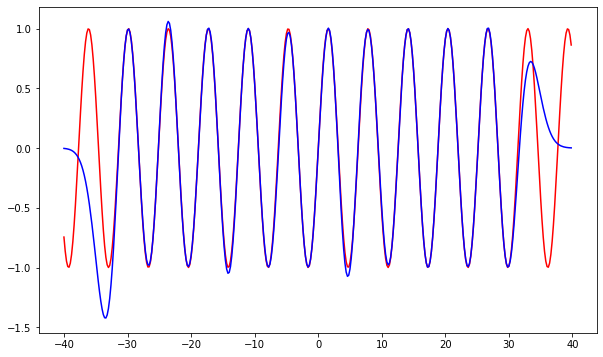

In [22]:
fig, ax = plt.subplots(figsize = (10, 6))
ax.plot(real_x, real_y, color="red")
ax.plot(real_x, predicted_y, color="blue")
plt.show()

Where blue and red overlap, the model predicts the data points well. Where they diverge, it's because it hasn't seen data in that area — you can see it happens outside $[-30, 30]$.

## Applying it to precipitation

Below I'm reading the data in from a file, and splitting it into train and test sets (the `x` and `real_x` above):

In [31]:
epochs = 30

In [51]:
x, y = [], []
with open("data.csv", "r") as file_in:
    lines = file_in.readlines() # Just so we read everything once...
    for line in lines[1:]:
        vals = line.split(",")
        x.append(int(vals[0]))
        y.append(float(vals[1]))

train_x = np.array(x[:1600]).reshape((1600, 1))
test_x = np.array(x).reshape((-1, 1))

train_y = np.array(y[:1600]).reshape((-1, 1))
test_y = np.array(y).reshape((-1, 1))

In [54]:
prec_model = SimpleGaussianProcessModel(train_x, train_y)

In [55]:
from emukit.core import DiscreteParameter

In [56]:
time_domain = np.linspace(0, 1_000_000, 10)
time = DiscreteParameter("time", time_domain)
param_space = ParameterSpace([time])

In [75]:
def swanky_fn(x, A=4, phi=1):
    return A*np.sin(np.pi*x + np.full(x.shape, phi))

In [76]:
exp_loop = ExperimentalDesignLoop(param_space, prec_model)

# This is the user function — the function we're emulating —,
# but I don't actually know this. I want to find a good fit
# without having to pick a candidate function myself.
loop.run_loop(swanky_fn, epochs) 

## Compute predictions

In [77]:
predicted_y, predicted_std = [], []
for x in test_x:
    y, var = prec_model.predict(np.array([x])) # Do I need to do this?
    std = np.sqrt(var)
    predicted_y.append(y)
    predicted_std.append(std)
    
predicted_y = np.array(predicted_y).flatten()
predicted_std = np.array(predicted_std).flatten()

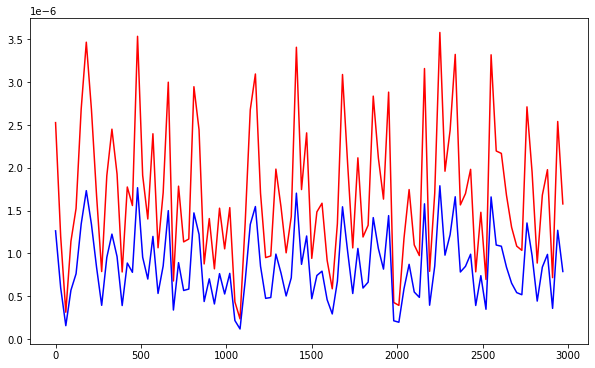

In [78]:
fig, ax = plt.subplots(figsize = (10, 6))
ax.plot(test_x[:100], test_y[:100], color="red")
ax.plot(test_x[:100], predicted_y[:100], color="blue")
plt.show()

Predicts 0 precipitation, and did not fit the data well, why? The trend on training data is correct, but the amplitude isn't. Maybe because `sin` isn't a good function to fit here.